In [1]:
!pip install torchvggish
!git clone https://github.com/YashNita/Animal-Sound-Dataset.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.2 MB/s eta 0:00:00
  Created wheel for torchvggish: filename=torchvggish-0.2-py3-none-any.whl size=10532 sha256=639ecdda007b1eefb5f42d156507c090d8b7a6a283c1269d316a17c60d8b77be
  Stored in directory: /root/.cache/pip/wheels/b8/92/3f/652f4935ffcb94cccc2754b4bec8a88c561e360cec6da24c22
Successfully built torchvggish
Cloning into 'Animal-Sound-Dataset'...
remote: Enumerating objects: 887, done.
remote: Total 887 (delta 0), reused 0 (delta 0), pack-reused 887
Receiving objects: 100% (887/887), 100.68 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Updating files: 100% (876/876), done.


In [2]:
from librosa import load
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms

from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [3]:
from torchvggish import vggish, vggish_input

# Initialise model and download weights
embedding_model = vggish()
embedding_model.eval()

Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish_pca_params-970ea276.pth" to /root/.cache/torch/hub/checkpoints/vggish_pca_params-970ea276.pth
100%|██████████| 177k/177k [00:00<00:00, 11.2MB/s]
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth
100%|██████████| 275M/275M [00:03<00:00, 82.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# functions (Masks & other stuff)


In [4]:
def load_wav(datafile,sample_frequency=16000):
    data ,sr = load(datafile,sr=sample_frequency)
    mel_numpy = vggish_input.waveform_to_examples(data=data, sample_rate=sample_frequency, return_tensor=False)
    mel_tensor = vggish_input.waveform_to_examples(data=data, sample_rate=sample_frequency, return_tensor=True)

    return data, mel_numpy, mel_tensor

def plotwav(data):
    stacked_spectrograms = np.concatenate(data, axis=0)
    plt.imshow(np.rot90(stacked_spectrograms))
    return


In [5]:
def MaskGenerator(num_batches, mask_bs, inp_shape_col=3*96,inp_shape_row=64, num_cells=7, p=0.5, nsd=2, dev='cpu'):
    for batch_i in range(num_batches):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)
        grid = (torch.rand(mask_bs, 1, *((num_cells,) * nsd), device=dev) < p).float()

        grid_up = F.interpolate(grid, size=(inp_shape_col,inp_shape_row), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (mask_bs,), device=dev)
        shift_y = torch.randint(0, num_cells, (mask_bs,), device=dev)

        masks = torch.empty((mask_bs, 1, inp_shape_col, inp_shape_row), device=dev)

        for i in range(mask_bs):
            masks[i] = grid_up[i, :,
                               shift_x[i]:shift_x[i] + inp_shape_col,
                               shift_y[i]:shift_y[i] + inp_shape_row]

        yield masks


In [6]:
def MaskGenerator_timefreq(num_batches, mask_bs, inp_shape_col=3*96,inp_shape_row=64, num_lines_time=2,num_lines_freq=2,line_width=1,line_height=1,dev="cpu"):
    for batch_i in range(num_batches):

        where_line_time = torch.randint(0, inp_shape_col, (mask_bs,num_lines_time),device=dev)
        where_line_freq = torch.randint(0, inp_shape_row, (mask_bs,num_lines_freq),device=dev)
        masks = torch.ones((mask_bs, 1, inp_shape_col, inp_shape_row),device=dev)

        for i in range(mask_bs):
            for j in range(num_lines_time):
                time_line = where_line_time[i,j]
                masks[i,:,time_line:time_line+line_width,:] = 0
            for k in range(num_lines_freq):
                freq_line = where_line_freq[i,k]
                masks[i,:,:,freq_line:freq_line+line_height] = 0
        yield masks

In [7]:
def MaskGenerator_time(num_batches, mask_bs, inp_shape_col=3*96,inp_shape_row=64, num_lines=2,line_width=1):
    for batch_i in range(num_batches):

        where_line = torch.randint(0, inp_shape_col, (mask_bs,num_lines))

        masks = torch.ones((mask_bs, 1, inp_shape_col, inp_shape_row))

        for i in range(mask_bs):
            for j in range(num_lines):
                this_line = where_line[i,j]
                masks[i,:,this_line:this_line+line_width,:] = 0
        yield masks

In [8]:
def MaskGenerator_freq(num_batches, mask_bs, inp_shape_col=3*96,inp_shape_row=64, num_lines=2,line_height=1):
    for batch_i in range(num_batches):

        where_line = torch.randint(0, inp_shape_row, (mask_bs,num_lines))

        masks = torch.ones((mask_bs, 1, inp_shape_col, inp_shape_row))

        for i in range(mask_bs):
            for j in range(num_lines):
                this_line = where_line[i,j]
                masks[i,:,:,this_line:this_line+line_height] = 0
        yield masks

# Classification on top of VGGish to test if the model is any good


In [9]:
data_folder = "/content/Animal-Sound-Dataset"
classes = np.array(sorted(os.listdir(data_folder)))[[4,6,10]]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

In [10]:
class_outputs = {class_name: torch.tensor([]) for class_name in classes}

In [11]:
for class_name in classes:
    class_path = os.path.join(data_folder, class_name)
    class_label = class_to_idx[class_name]

    for filename in os.listdir(class_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(class_path, filename)
            #waveform, _ = vggish_input.wavfile_to_samples(file_path)
            waveform, sr = load(file_path,sr=16000)
            examples = vggish_input.waveform_to_examples(waveform, sample_rate=sr, return_tensor=True)
            try:
                out = embedding_model(examples).mean(dim=0)
                # Check if the shape is [128]
                if out.shape == torch.Size([128]):
                    class_outputs[class_name] = torch.cat((class_outputs[class_name], out.unsqueeze(0)), dim=0)
                else:
                    print(f"Ignoring {file_path} due to incorrect shape: {out.shape}")
            except Exception as e:
                print(f"An exception occurred for {file_path}: {e}")

Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_67.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_19.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_53.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_9.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_86.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_8.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_93.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_70.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_17.wav due to incorrect shape: torch.Size([])
Ignoring /content/Animal-Sound-Dataset/Kedi-Part1/cat_4.wav due to incorrect shape: torch.Size([])
Ign

In [12]:
# Concatenate tensors across all classes
X = torch.cat([class_outputs[class_name] for class_name in classes], dim=0).detach().numpy()

# Create labels corresponding to each class
y = torch.cat([torch.full((class_outputs[class_name].size(0),), class_to_idx[class_name]) for class_name in classes], dim=0).detach().numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9761904761904762


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
#Set a random seed for reproducibility
sns.set_theme()
np.random.seed(42)

#Create a single subplot
fig, axes = plt.subplots(1, 1, figsize=(10, 8), squeeze=False)

def plot_latents(ax, z, y):
    # No need for z.to('cpu') if z is a NumPy array
    palette = sns.color_palette("husl", len(set(y)))
    z = TSNE(n_components=2, random_state=42).fit_transform(z)

    class_mapping = {0: 'Cat', 1: 'Dog', 2: 'Bird'}

    unique_labels = set(y)

    for label in unique_labels:
        indices = (y == label)
        ax.scatter(z[indices, 0], z[indices, 1], color=palette[int(label)], label=f'Class {label} ({class_mapping[label]})')

    ax.set_title('Latent Representations')
    ax.legend()

#Call the function with your data
plot_latents(axes[0, 0], X_train, y_train)

#Show the plot
plt.show()

In [13]:
#import pickle

# save
#with open('model.pkl','wb') as f:
#    pickle.dump(model,f)

In [14]:
for class_name in classes:
    print(class_name)

Kedi-Part1
Kopek-Part1
Kus-Part1


In [15]:
class AudioLogisticRegressionDataset:
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.classes = np.array(sorted(os.listdir(data_folder)))[[5,7,11]]
        #self.classes.remove('.ipynb_checkpoints')
        #self.classes.remove('.git')
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.data, self.labels = self.load_data()

    def load_data(self):
        data = torch.empty((128))
        labels = np.array([])

        for class_name in self.classes:
            class_path = os.path.join(self.data_folder, class_name)
            class_label = self.class_to_idx[class_name]

            for filename in os.listdir(class_path):
                if filename.endswith(".wav"):
                    file_path = os.path.join(class_path, filename)
                    #waveform, _ = vggish_input.wavfile_to_samples(file_path)
                    waveform, sr = load(file_path,sr=16000)
                    examples = vggish_input.waveform_to_examples(waveform, sample_rate=sr, return_tensor=True)
                    try:
                        out = embedding_model(examples).mean(dim=0)
                        labels.append(class_label)
                    except:
                        print("An exception occurred")


        return np.concatenate(data), np.array(labels)

# Relax Method

Try to find patterns by trying three different animals and two examples


In [17]:
bird, bird_np1, bird1 = load_wav(datafile="/content/Animal-Sound-Dataset/Kus-Part1/Kus_1.wav")
bird, bird_np2, bird2 = load_wav(datafile="/content/Animal-Sound-Dataset/Kus-Part1/Kus_100.wav")
dog, dog_np1, dog1 = load_wav(datafile="/content/Animal-Sound-Dataset/Kopek-Part1/dog_17.wav")
dog, dog_np2, dog2 = load_wav(datafile="/content/Animal-Sound-Dataset/Kopek-Part1/dog_10.wav")
cat, cat_np1, cat1 = load_wav(datafile="/content/Animal-Sound-Dataset/Kedi-Part1/cat_10.wav")
cat, cat_np2, cat2 = load_wav(datafile="/content/Animal-Sound-Dataset/Kedi-Part1/cat_4.wav")
animals = {"b1":bird1[0],
           "b2":bird2[0],
           "d1":dog1[0],
           "d2":dog2[0],
           "c1":cat1[0],
           "c2":cat2[0]}

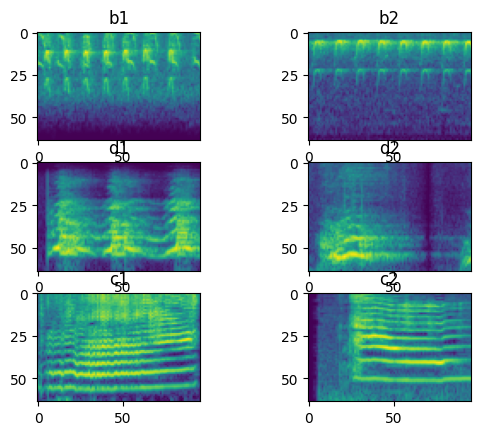

In [19]:
plt.subplot(3,2,1)
plt.imshow(np.rot90(bird1[0].squeeze().detach().numpy()))
plt.title("b1")
plt.subplot(3,2,2)
plt.imshow(np.rot90(bird2[0].squeeze().detach().numpy()))
plt.title("b2")
plt.subplot(3,2,3)
plt.imshow(np.rot90(dog1[0].squeeze().detach().numpy()))
plt.title("d1")
plt.subplot(3,2,4)
plt.imshow(np.rot90(dog2[0].squeeze().detach().numpy()))
plt.title("d2")
plt.subplot(3,2,5)
plt.imshow(np.rot90(cat1[0].squeeze().detach().numpy()))
plt.title("c1")
plt.subplot(3,2,6)
plt.imshow(np.rot90(cat2[0].squeeze().detach().numpy()))
plt.title("c2")
plt.show()

In [20]:
original_spectrogram = cat2[0]
replacement_value = original_spectrogram.mean()
for batch_i, mask in MaskGenerator(num_batches=1, mask_bs=2,inp_shape_col=96,inp_shape_row=64):
    relax = np.rot90((mask * original_spectrogram).squeeze().detach().numpy())
    #relax = np.rot90((torch.where(relax == 0,replacement_value,relax)).squeeze().detach().numpy())
    #relax = np.rot90((torch.where(mask == 0,replacement_value,original_spectrogram)).squeeze().detach().numpy())
original_spectrogram = cat2[0]
replacement_value = original_spectrogram.mean()
for batch_i, mask in MaskGenerator_time(num_batches=1, mask_bs=2,inp_shape_col=96,inp_shape_row=64, num_lines=6,line_width=5):
    time = np.rot90((torch.where(mask == 0,replacement_value,original_spectrogram)).squeeze().detach().numpy())
original_spectrogram = cat2[0]
replacement_value = original_spectrogram.mean()
for batch_i, mask in MaskGenerator_freq(num_batches=1, mask_bs=2,inp_shape_col=96,inp_shape_row=64, num_lines=6,line_height=5):
    freq = np.rot90((torch.where(mask == 0,replacement_value,original_spectrogram)).squeeze().detach().numpy())
    #freq = freq.squeeze().detach().numpy()

#### Different masks

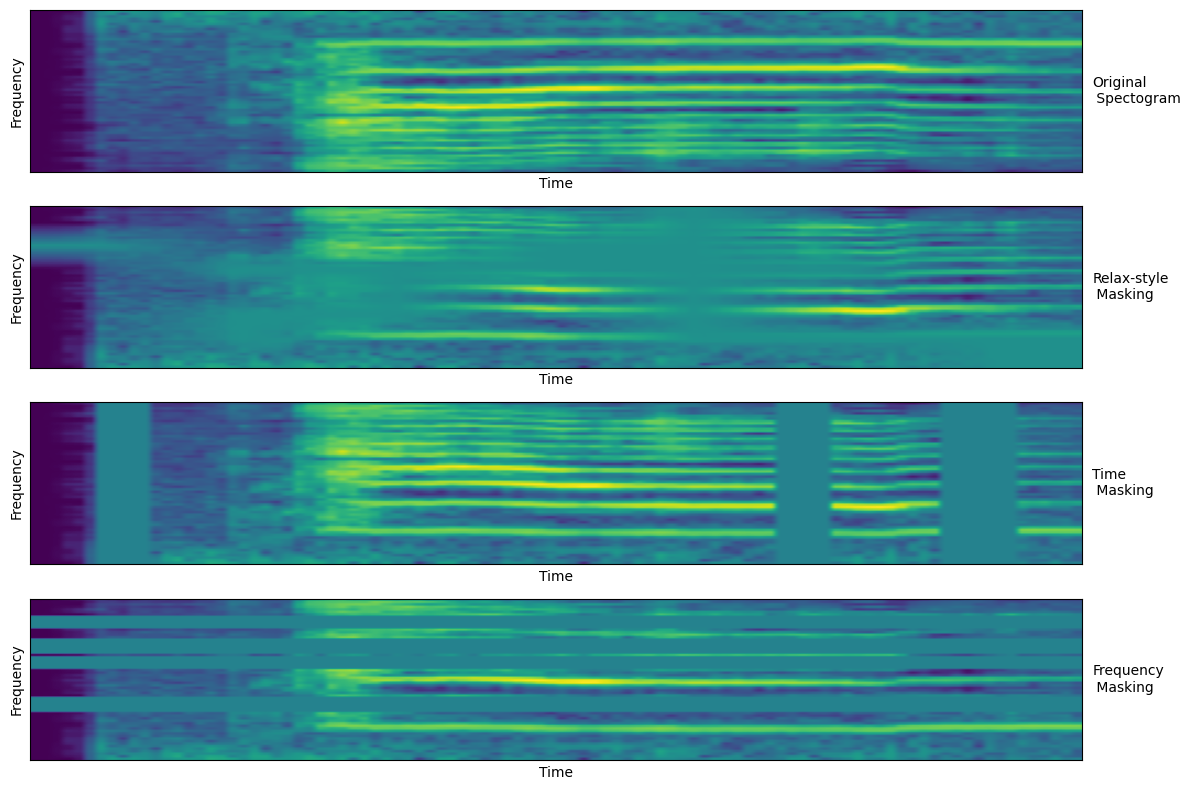

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# Set font family to 'serif'
plt.rcParams['font.family'] = "sans-serif"

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 8))

# Plot Original_spectrogram
im = axs[0].imshow(np.rot90(original_spectrogram.squeeze().detach().numpy()), aspect='auto', origin='lower', cmap='viridis')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

# Remove tick marks
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot Relax
im = axs[1].imshow(relax, aspect='auto')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

# Remove tick marks
axs[1].set_xticks([])
axs[1].set_yticks([])

# Plot time (assuming it's a line plot, adjust as needed)
axs[2].imshow(time, label='time', aspect='auto')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

# Remove tick marks
axs[2].set_xticks([])
axs[2].set_yticks([])

# Plot freq (assuming it's a line plot, adjust as needed)
im = axs[3].imshow(freq, label='freq', aspect='auto')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

# Remove tick marks
axs[3].set_xticks([])
axs[3].set_yticks([])

# Add text next to each plot on the right side saying "pp"
axs[0].text(1.01, 0.5, 'Original\n Spectogram', transform=axs[0].transAxes, va='center', ha='left', fontsize=10)
axs[1].text(1.01, 0.5, 'Relax-style\n Masking', transform=axs[1].transAxes, va='center', ha='left', fontsize=10)
axs[2].text(1.01, 0.5, 'Time\n Masking', transform=axs[2].transAxes, va='center', ha='left', fontsize=10)
axs[3].text(1.01, 0.5, 'Frequency\n Masking', transform=axs[3].transAxes, va='center', ha='left', fontsize=10)


# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.savefig('maskingsdone.png')
plt.show()


Batch 1 of masked images.


<Figure size 640x480 with 0 Axes>

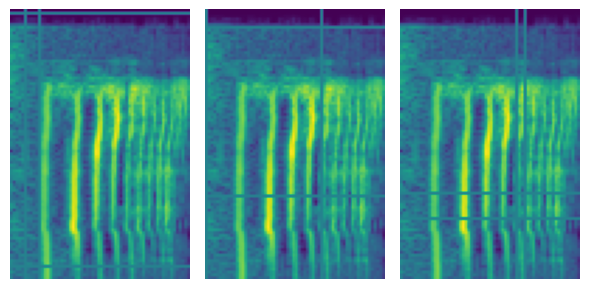

Batch 2 of masked images.


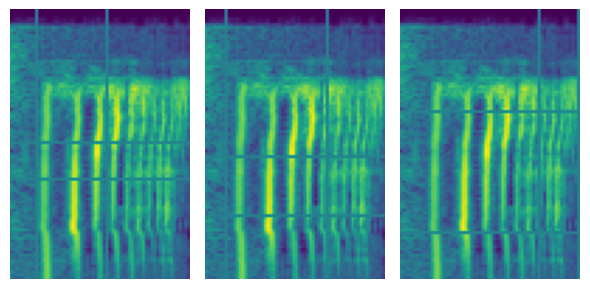

Batch 3 of masked images.


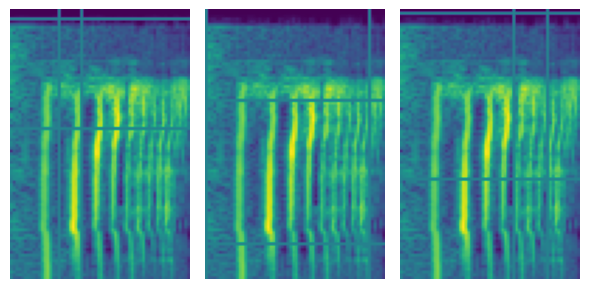

In [22]:
example_image_1 = cat2[0]

plt.figure(1)
for batch_i, mask in enumerate(MaskGenerator_timefreq(num_batches=3, mask_bs=3,inp_shape_col=example_image_1.shape[0]*96,inp_shape_row=64)):
  plt.figure(figsize=(6,4))
  print(f"Batch {batch_i+1} of masked images.")
  replacement_value = example_image_1.mean()
  example_image_1_masked = torch.where(mask == 0,replacement_value,example_image_1)
  #example_image_1_masked = example_image_1*mask
  #example_image_1_masked2 = torch.where(torch.eq(mask, 0), torch.tensor(replacement_value, dtype=torch.float32), example_image_1)
  #example_image_1_masked = torch.where(example_image_1_masked.abs() == 0.0,replacement_value,example_image_1_masked)
  plt.subplot(1,3,1)
  plt.imshow(example_image_1_masked[0].squeeze().detach().numpy())
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(example_image_1_masked[1].squeeze().detach().numpy())
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(example_image_1_masked[2].squeeze().detach().numpy())
  plt.axis('off')
  plt.tight_layout()
  plt.show()

Batch 1 of masked images.


<Figure size 640x480 with 0 Axes>

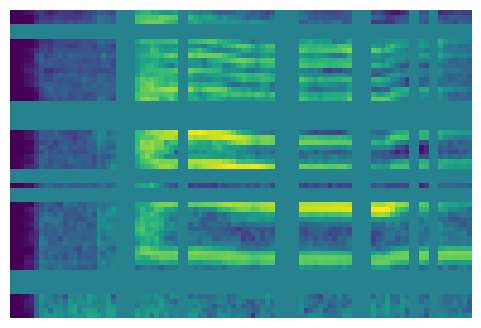

Batch 2 of masked images.


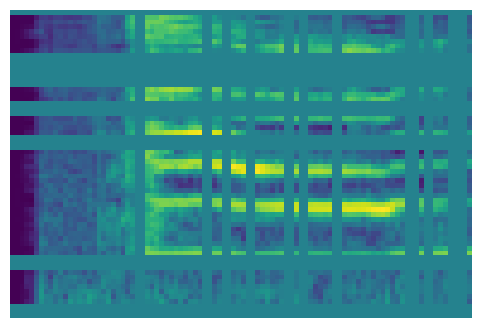

In [23]:
example_image_1 = cat2[0]

plt.figure(1)
for batch_i, mask in enumerate(MaskGenerator_timefreq(num_batches=2, mask_bs=1,inp_shape_col=example_image_1.shape[0]*96,num_lines_freq=8,line_height=3,num_lines_time=12,line_width=2)):
  plt.figure(figsize=(6,4))
  print(f"Batch {batch_i+1} of masked images.")
  replacement_value = example_image_1.mean()
  example_image_1_masked = torch.where(mask == 0,replacement_value,example_image_1)
  exampleimaeg = example_image_1*mask
  #example_image_1_masked2 = torch.where(torch.eq(mask, 0), torch.tensor(replacement_value, dtype=torch.float32), example_image_1)
  #example_image_1_masked = torch.where(example_image_1_masked.abs() == 0.0,replacement_value,example_image_1_masked)
  #plt.subplot(1,3,1)
  plt.imshow(np.rot90(example_image_1_masked.squeeze().detach().numpy()))
  plt.axis('off')
  plt.show()
  #plt.axis('off')
  #plt.subplot(1,3,2)
  #plt.imshow(example_image_1_masked[1].squeeze().detach().numpy())
  #plt.axis('off')
  #plt.subplot(1,3,3)
  #plt.imshow(example_image_1_masked[2].squeeze().detach().numpy())
  #plt.axis('off')
  #plt.tight_layout()
  #plt.show()

In [34]:
def RELAX(data, masking="relax",mask_bs=100,num_batches=80,num_cells=7,p=0.5,num_lines_time=48,num_lines_freq=32,line_width=1,line_height=1):
    x = data.unsqueeze(dim=0)
    torch.manual_seed(100)

    pdist = nn.CosineSimilarity(dim=1)
    replacement_value = x.mean()
    mask_bs, num_batches = mask_bs, num_batches
    num_cells=num_cells
    p=p
    num_lines_time = num_lines_time
    num_lines_freq = num_lines_freq
    line_width = line_width
    line_height = line_height
    dev="cpu"

    inp_shape_col, inp_shape_row = 96,64

    with torch.no_grad():
        h_star = embedding_model(x)
        h_star = h_star.expand(mask_bs, -1)

        saliency = torch.zeros((inp_shape_col, inp_shape_row), device=dev)
        saliency_var = torch.zeros((inp_shape_col, inp_shape_row), device=dev)

        #num_batches, mask_bs, inp_shape_col=3*96,inp_shape_row=64, num_cells=7, p=0.5, nsd=2, dev='cpu'

        if masking == "relax":
            maskG = MaskGenerator(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_cells=num_cells, p=p)
            maskG2 = MaskGenerator(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_cells=num_cells, p=p)
        elif masking == "time":
            maskG = MaskGenerator_time(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_time,line_width=line_width)
            maskG2 = MaskGenerator_time(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_time,line_width=line_width)
        elif masking == "freq":
            maskG = MaskGenerator_freq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_freq,line_height=line_height)
            maskG2 = MaskGenerator_freq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_freq,line_height=line_height)
        elif masking == "time_freq":
            maskG = MaskGenerator_timefreq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines_time=num_lines_time,num_lines_freq=num_lines_freq,line_width=line_width,line_height=line_height)
            maskG2 = MaskGenerator_timefreq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines_time=num_lines_time,num_lines_freq=num_lines_freq,line_width=line_width,line_height=line_height)


        for mask_idx, mask in enumerate(tqdm.tqdm(maskG,total=num_batches)):

            x_mask = torch.where(mask == 0,replacement_value,x)
            #x_mask = x * mask
            out = embedding_model(x_mask)

            out = pdist(h_star, out)[:, None, None, None]

            saliency += torch.mean(out * mask, dim=(0, 1))

        saliency /= (num_batches*0.5)

        for mask_idx, mask in enumerate(tqdm.tqdm(maskG2,total=num_batches)):

            x_mask = torch.where(mask == 0,replacement_value,x)
            #x_mask = x * mask
            out = embedding_model(x_mask)

            out = pdist(h_star, out)[:, None, None, None]

            var = (out-saliency[None, None])**2

            var = torch.mean(var * mask, dim=(0, 1))

            saliency_var += var

        saliency_var /= ((num_batches-1)*0.5)
    return saliency, saliency_var


In [25]:
def RELAX2(data, masking="relax",mask_bs=100,num_batches=80,num_cells=7,p=0.5,num_lines_time=48,num_lines_freq=32,line_width=1,line_height=1):
    x = data.unsqueeze(dim=0)
    torch.manual_seed(100)

    pdist = nn.CosineSimilarity(dim=1)
    replacement_value = x.min()
    mask_bs, num_batches = mask_bs, num_batches
    num_cells=num_cells
    p=p
    num_lines_time = num_lines_time
    num_lines_freq = num_lines_freq
    line_width = line_width
    line_height = line_height
    dev="cpu"

    inp_shape_col, inp_shape_row = 96,64

    with torch.no_grad():
        h_star = embedding_model(x)
        h_star = h_star.expand(mask_bs, -1)

        saliency = torch.zeros((inp_shape_col, inp_shape_row), device=dev)
        saliency_var = torch.zeros((inp_shape_col, inp_shape_row), device=dev)

        #num_batches, mask_bs, inp_shape_col=3*96,inp_shape_row=64, num_cells=7, p=0.5, nsd=2, dev='cpu'

        if masking == "relax":
            maskG = MaskGenerator(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_cells=num_cells, p=p)
            maskG2 = MaskGenerator(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_cells=num_cells, p=p)
        elif masking == "time":
            maskG = MaskGenerator_time(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_time,line_width=line_width)
            maskG2 = MaskGenerator_time(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_time,line_width=line_width)
        elif masking == "freq":
            maskG = MaskGenerator_freq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_freq,line_height=line_height)
            maskG2 = MaskGenerator_freq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines=num_lines_freq,line_height=line_height)
        elif masking == "time_freq":
            maskG = MaskGenerator_timefreq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines_time=num_lines_time,num_lines_freq=num_lines_freq,line_width=line_width,line_height=line_height)
            maskG2 = MaskGenerator_timefreq(num_batches=num_batches, inp_shape_col=inp_shape_col, inp_shape_row=inp_shape_row, mask_bs=mask_bs,num_lines_time=num_lines_time,num_lines_freq=num_lines_freq,line_width=line_width,line_height=line_height)

        for mask_idx, mask in enumerate(tqdm.tqdm(maskG,total=num_batches)):

            x_mask = torch.where(mask == 0,replacement_value,x)
            #x_mask = x * mask
            out = embedding_model(x_mask)

            out = pdist(h_star, out)[:, None, None, None]

            saliency += torch.mean(out * mask, dim=(0, 1))

        saliency /= (num_batches*0.5)

        #for mask_idx, mask in enumerate(tqdm.tqdm(maskG2,total=num_batches)):

        #    x_mask = torch.where(mask == 0,replacement_value,x)
            #x_mask = x * mask
        #    out = embedding_model(x_mask)

        #    out = pdist(h_star, out)[:, None, None, None]

        #    var = (out-saliency[None, None])**2

        #    var = torch.mean(var * mask, dim=(0, 1))

        #    saliency_var += var

     #   saliency_var /= ((num_batches-1)*0.5)
    return saliency#, saliency_var


Relax-style masking

In [26]:
relax_sal = {}
relax_var = {}
for animal in animals:
    relax_sal[animal], relax_var[animal] = RELAX(animals[animal], masking="relax",mask_bs=100,num_batches=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Time masking

In [27]:
relax_time_sal = {}
relax_time_var = {}
for animal in animals:
    relax_time_sal[animal], relax_time_var[animal] = RELAX(animals[animal], masking="time",mask_bs=100,num_batches=10,num_lines_time=12,line_width=4)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Frequency masking

In [28]:
relax_freq_sal = {}
relax_freq_var = {}
for animal in animals:
    relax_freq_sal[animal], relax_freq_var[animal] = RELAX(animals[animal], masking="freq",mask_bs=100,num_batches=10,num_lines_freq=8,line_height=3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Time-frequency masking

In [35]:
relax_tf_sal = {}
relax_tf_var = {}
for animal in animals:
    relax_tf_sal[animal], relax_tf_var[animal] = RELAX(animals[animal], masking="time_freq",mask_bs=100,num_batches=10,num_lines_freq=8,line_height=3,num_lines_time=8,line_width=3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#### Plot functions

In [36]:
# Define a function to create the combined plot
def plot_combinedtime(original, importance, animal_name, importance_name):
    #importance = torch.where(importance == importance.max(), importance.mean(), importance)
    original_rotated = np.rot90(original[:,3:,:].squeeze().detach().numpy())
    importance_rotated = np.rot90(importance[3:,:].detach().numpy())

    # Create a combined plot
    plt.imshow(original_rotated, cmap='viridis')  # You can change 'viridis' to the desired colormap
    plt.imshow(importance_rotated, alpha=0.5, cmap='bwr')
    plt.title(f"{importance_name}")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.xticks([])
    plt.yticks([])

    #plt.show()
# Define a function to create the combined plot
def plot_combinedfreq(original, importance, animal_name, importance_name):
    #importance = torch.where(importance == importance.max(), importance.mean(), importance)
    original_rotated = np.rot90(original[:,:,3:].squeeze().detach().numpy())
    importance_rotated = np.rot90(importance[:,3:].detach().numpy())

    # Create a combined plot
    plt.imshow(original_rotated, cmap='viridis')  # You can change 'viridis' to the desired colormap
    plt.imshow(importance_rotated, alpha=0.5, cmap='bwr')
    plt.title(f"{importance_name}")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.xticks([])
    plt.yticks([])
    #plt.show()
def plot_combinedtimefreq(original, importance, animal_name, importance_name):
    #importance = torch.where(importance == importance.max(), importance.mean(), importance)
    original_rotated = np.rot90(original[:,3:,3:].squeeze().detach().numpy())
    importance_rotated = np.rot90(importance[3:,3:].detach().numpy())

    # Create a combined plot
    plt.imshow(original_rotated, cmap='viridis')  # You can change 'viridis' to the desired colormap
    plt.imshow(importance_rotated, alpha=0.5, cmap='bwr')
    plt.title(f"{importance_name}")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.xticks([])
    plt.yticks([])

    #plt.show()
    # Define a function to create the combined plot
def plot_original(original, importance, animal_name, importance_name):
    #importance = torch.where(importance == importance.max(), importance.mean(), importance)
    original_rotated = np.rot90(original[:,3:,:].squeeze().detach().numpy())
    #importance_rotated = np.rot90(importance[3:,:].detach().numpy())

    # Create a combined plot
    plt.imshow(original_rotated, cmap='viridis')  # You can change 'viridis' to the desired colormap
    #plt.imshow(importance_rotated, alpha=0.4, cmap='bwr')
    plt.title(f"Original - {animal_name}") #- {importance_name}")
    plt.axis('off')

Original spectograms

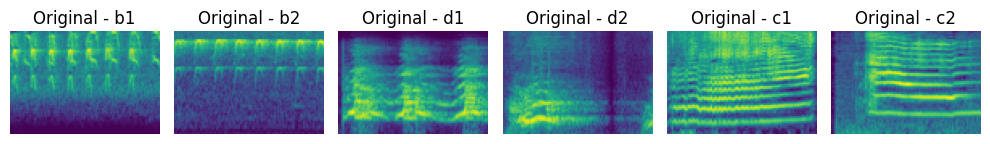

In [37]:
plt.figure(figsize=(10, 8))
i = 1
for animal_name, animal_spectrogram in animals.items():
    # Assuming relax_tf_sal, relax_freq_sal, relax_time_sal have tensors for each animal
    time_sal = relax_sal.get(animal_name, None)
    time_var = relax_var.get(animal_name, None)
    plt.subplot(1,len(animals), i)
    plot_original(animal_spectrogram, time_sal, animal_name, "Saliency")  # Assuming 'viridis' colormap, you can change it as needed
    i = i+1

plt.tight_layout()
plt.show()

#### Main result

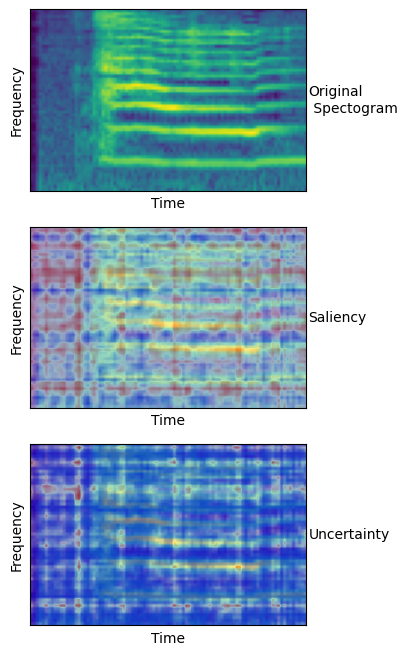

In [40]:
import matplotlib.pyplot as plt
import numpy as np


# Set font family to 'serif'
plt.rcParams['font.family'] = "sans-serif"

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# Plot Original_spectrogram
im = axs[0].imshow(np.rot90(animals["c2"][:,3:,3:].squeeze().detach().numpy()))
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

# Remove tick marks
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot Relax
axs[1].imshow(np.rot90(animals["c2"][:,3:,3:].squeeze().detach().numpy()))
im = axs[1].imshow(np.rot90(relax_tf_sal["c2"][3:,3:].squeeze().detach().numpy()), alpha=0.5, cmap='bwr')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

# Remove tick marks
axs[1].set_xticks([])
axs[1].set_yticks([])

# Plot time (assuming it's a line plot, adjust as needed)
axs[2].imshow(np.rot90(animals["c2"][:,3:,3:].squeeze().detach().numpy()))
axs[2].imshow(np.rot90(relax_tf_var["c2"][3:,3:].squeeze().detach().numpy()), label='time', alpha=0.5, cmap='bwr')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

# Remove tick marks
axs[2].set_xticks([])
axs[2].set_yticks([])


# Add text next to each plot on the right side saying "pp"
axs[0].text(1.01, 0.5, 'Original\n Spectogram', transform=axs[0].transAxes, va='center', ha='left', fontsize=10)
axs[1].text(1.01, 0.5, 'Saliency', transform=axs[1].transAxes, va='center', ha='left', fontsize=10)
axs[2].text(1.01, 0.5, 'Uncertainty', transform=axs[2].transAxes, va='center', ha='left', fontsize=10)


# Adjust layout for better appearance
#plt.tight_layout()

# Show the plot
plt.savefig('cat_example.png')
plt.show()

## Relax-style plot

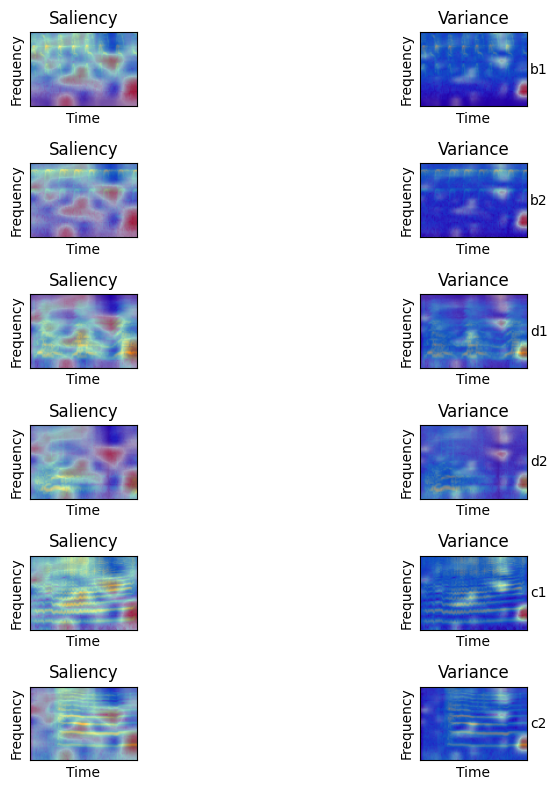

In [41]:
# Assuming animals is a dictionary with animal names as keys and corresponding spectrograms as values
plt.figure(figsize=(10, 8))
i = 1

# Loop through each animal and each type of importance plot
for animal_name, animal_spectrogram in animals.items():
    # Assuming relax_tf_sal, relax_freq_sal, relax_time_sal have tensors for each animal
    time_sal = relax_sal.get(animal_name, None)
    time_var = relax_var.get(animal_name, None)

    #plot original
    #plt.subplot(len(animals), 3, i)
    #plot_original(animal_spectrogram, time_sal, animal_name, "Saliency")  # Assuming 'viridis' colormap, you can change it as needed
    # Plot time_sal
    plt.subplot(len(animals), 2, i)
    plot_combinedtime(animal_spectrogram, time_sal, animal_name, "Saliency")

    # Plot time_var
    plt.subplot(len(animals), 2, i + 1)
    plot_combinedtime(animal_spectrogram, time_var, animal_name, "Variance")
    plt.text(95, 64/2, animal_name, va='center', ha='left', fontsize=10)

    i += 2
plt.savefig('relax_results.png')
plt.tight_layout()
plt.show()

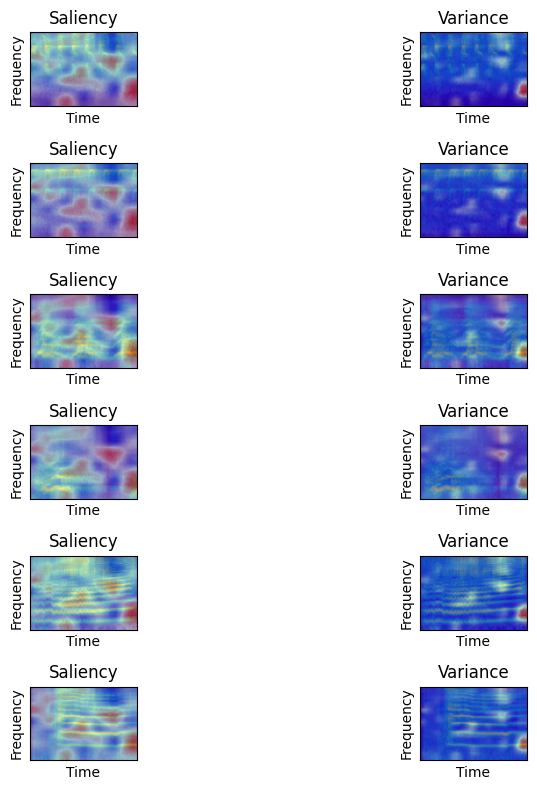

In [42]:
# Assuming animals is a dictionary with animal names as keys and corresponding spectrograms as values
plt.figure(figsize=(10, 8))
i = 1

# Loop through each animal and each type of importance plot
for animal_name, animal_spectrogram in animals.items():
    # Assuming relax_tf_sal, relax_freq_sal, relax_time_sal have tensors for each animal
    time_sal = relax_sal.get(animal_name, None)
    time_var = relax_var.get(animal_name, None)

    # Plot time_sal
    plt.subplot(len(animals), 2, i)
    plot_combinedtime(animal_spectrogram, time_sal, animal_name, "Saliency")

    # Plot time_var
    plt.subplot(len(animals), 2, i + 1)
    plot_combinedtime(animal_spectrogram, time_var, animal_name, "Variance")

    i += 2

plt.tight_layout()
plt.show()

## Time plot

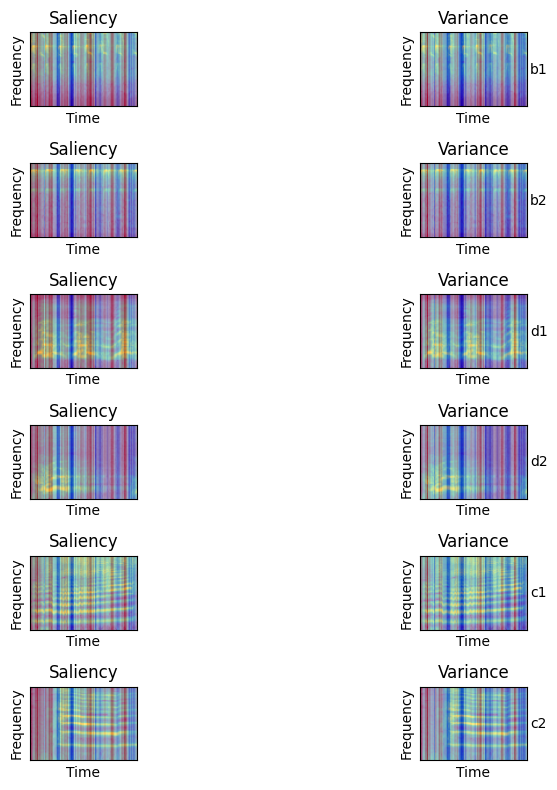

In [43]:
# Assuming animals is a dictionary with animal names as keys and corresponding spectrograms as values
plt.figure(figsize=(10, 8))
i = 1

# Loop through each animal and each type of importance plot
for animal_name, animal_spectrogram in animals.items():
    # Assuming relax_tf_sal, relax_freq_sal, relax_time_sal have tensors for each animal
    time_sal = relax_time_sal.get(animal_name, None)
    time_var = relax_time_var.get(animal_name, None)

    #plot original
    #plt.subplot(len(animals), 3, i)
    #plot_original(animal_spectrogram, time_sal, animal_name, "Saliency")  # Assuming 'viridis' colormap, you can change it as needed
    # Plot time_sal
    plt.subplot(len(animals), 2, i)
    plot_combinedtime(animal_spectrogram, time_sal, animal_name, "Saliency")

    # Plot time_var
    plt.subplot(len(animals), 2, i + 1)
    plot_combinedtime(animal_spectrogram, time_var, animal_name, "Variance")
    plt.text(95, 64/2, animal_name, va='center', ha='left', fontsize=10)

    i += 2
plt.savefig('timefreq_results.png')
plt.tight_layout()
plt.show()

## Freq plot

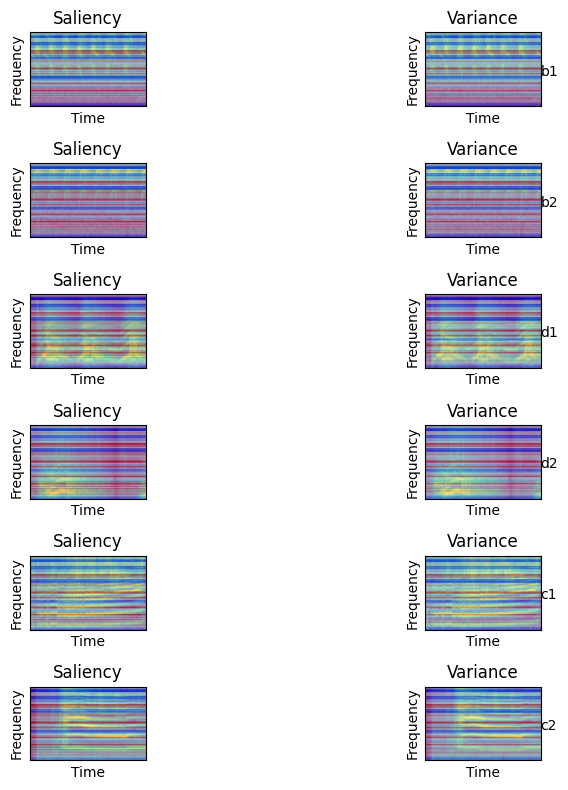

In [44]:
# Assuming animals is a dictionary with animal names as keys and corresponding spectrograms as values
plt.figure(figsize=(10, 8))
i = 1

# Loop through each animal and each type of importance plot
for animal_name, animal_spectrogram in animals.items():
    # Assuming relax_tf_sal, relax_freq_sal, relax_time_sal have tensors for each animal
    time_sal = relax_freq_sal.get(animal_name, None)
    time_var = relax_freq_var.get(animal_name, None)

    #plot original
    #plt.subplot(len(animals), 3, i)
    #plot_original(animal_spectrogram, time_sal, animal_name, "Saliency")  # Assuming 'viridis' colormap, you can change it as needed
    # Plot time_sal
    plt.subplot(len(animals), 2, i)
    plot_combinedfreq(animal_spectrogram, time_sal, animal_name, "Saliency")

    # Plot time_var
    plt.subplot(len(animals), 2, i + 1)
    plot_combinedfreq(animal_spectrogram, time_var, animal_name, "Variance")
    plt.text(95, 64/2, animal_name, va='center', ha='left', fontsize=10)

    i += 2
plt.savefig('timefreq_results.png')
plt.tight_layout()
plt.show()

## TF  plot

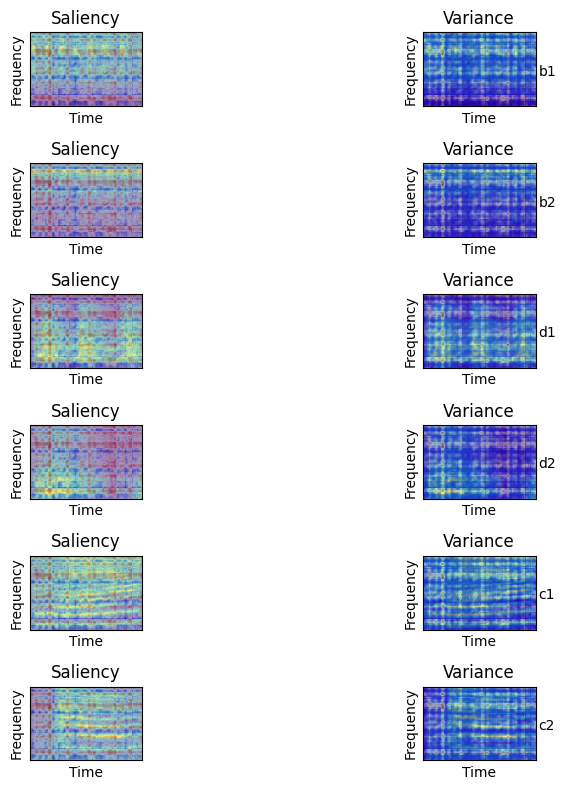

In [45]:
# Assuming animals is a dictionary with animal names as keys and corresponding spectrograms as values
plt.figure(figsize=(10, 8))
i = 1

# Loop through each animal and each type of importance plot
for animal_name, animal_spectrogram in animals.items():
    # Assuming relax_tf_sal, relax_freq_sal, relax_time_sal have tensors for each animal
    time_sal = relax_tf_sal.get(animal_name, None)
    time_var = relax_tf_var.get(animal_name, None)

    #plot original
    #plt.subplot(len(animals), 3, i)
    #plot_original(animal_spectrogram, time_sal, animal_name, "Saliency")  # Assuming 'viridis' colormap, you can change it as needed
    # Plot time_sal
    plt.subplot(len(animals), 2, i)
    plot_combinedtimefreq(animal_spectrogram, time_sal, animal_name, "Saliency")

    # Plot time_var
    plt.subplot(len(animals), 2, i + 1)
    plot_combinedtimefreq(animal_spectrogram, time_var, animal_name, "Variance")
    plt.text(95, 64/2, animal_name, va='center', ha='left', fontsize=10)

    i += 2
plt.savefig('timefreq_results.png')
plt.tight_layout()
plt.show()

In [ ]:

animals = {"b1":bird1[0],

           "d1":dog1[0],

           "c1":cat1[0]}

In [46]:
pixels_sorted = torch.zeros((6,6144))
h_star = {}
pdist = nn.CosineSimilarity(dim=1)
pd = {}
i = 0
for animal_name, animal_spectrogram in animals.items():
    importance = relax_tf_sal[animal_name]
    pixels_sorted[i,:] = torch.argsort(-importance.view(-1))
    h_star[animal_name] = embedding_model(animal_spectrogram.unsqueeze(dim=0)).unsqueeze(dim=0)
    #print(h_star[animal_name].shape)
    pd[animal_name] = pdist(h_star[animal_name], h_star[animal_name])[:, None, None, None]
    i = i+1
pd

{'b1': tensor([[[[1.0000]]]], grad_fn=<UnsqueezeBackward0>),
 'b2': tensor([[[[1.0000]]]], grad_fn=<UnsqueezeBackward0>),
 'd1': tensor([[[[1.0000]]]], grad_fn=<UnsqueezeBackward0>),
 'd2': tensor([[[[1.]]]], grad_fn=<UnsqueezeBackward0>),
 'c1': tensor([[[[1.]]]], grad_fn=<UnsqueezeBackward0>),
 'c2': tensor([[[[1.]]]], grad_fn=<UnsqueezeBackward0>)}

In [ ]:
pixels_sorted = torch.zeros((6,6144))
h_star = torch.zeros((6,128))
h_star = {}
pdist = nn.CosineSimilarity(dim=1)

i = 0
for animal_name, animal_spectrogram in animals.items():

    importance = relax_tf_sal[animal_name]
    pixels_sorted[i,:] = torch.argsort(-importance.view(-1))
    h_star[animal_name] = embedding_model(animal_spectrogram.unsqueeze(dim=0)).unsqueeze(dim=0)
    #pdist(h_star, out)[:, None, None, None]
    i = i+1

y = np.array([0,0,1,1,2,2])
spectograms = dict(animals)


batch_size = 32*2
num_batches = int(6144 / batch_size)
#pf_curve = np.array([])
pf_curve_min = torch.zeros((num_batches))

for i in range(num_batches):
    #x = np.empty([6,128])
    x = torch.zeros((6,128))
    #pd = np.empty([6,1])
    pd = torch.zeros((6,1))
    j = 0
    p = pixels_sorted[:,i*batch_size:i*batch_size+batch_size].numpy().astype(int)

    for animal_name, animal_spectrogram in animals.items():
        if i == 0:
            replacement_value = spectograms[animal_name].min()

        # change the spectogram of animal
        spectograms[animal_name].view(-1)[p[j]] = replacement_value
        #Calculate latent space of the new spectogram and store it in x[j,:]
        x[j,:] = embedding_model(spectograms[animal_name].unsqueeze(dim=0))#.detach().numpy()
        pd[j,:] = pdist(h_star[animal_name], x[j,:].unsqueeze(dim=0))[:, None, None, None]
        j = j+1
    #y_pred = model.predict(x)
    #mse = mean_squared_error(y, y_pred)
    # Calculate mean squared error (or other regression metric)

    #Get det model probabilities from all 6 spectograms
    #pf_curve = np.append(pf_curve,accuracy_score(y,y_pred))
    #pf_curve = np.append(pf_curve,mse)
    #pf_curve = np.append(pf_curve,np.max(np.abs(model.decision_function(x)),axis=1).mean())
    pf_curve_min[i] = pd.mean()


In [ ]:
bird, bird_np1, bird1 = load_wav(datafile="/content/Animal-Sound-Dataset/Kus-Part1/Kus_1.wav")

dog, dog_np1, dog1 = load_wav(datafile="/content/Animal-Sound-Dataset/Kopek-Part1/dog_17.wav")

cat, cat_np1, cat1 = load_wav(datafile="/content/Animal-Sound-Dataset/Kedi-Part1/cat_10.wav")
animals = {"b1":bird1[0],

           "d1":dog1[0],

           "c1":cat1[0]}

In [ ]:
pixels_sorted = torch.zeros((6,6144))
h_star = torch.zeros((6,128))
h_star = {}
pdist = nn.CosineSimilarity(dim=1)

i = 0
for animal_name, animal_spectrogram in animals.items():

    importance = relax_tf_sal[animal_name]
    pixels_sorted[i,:] = torch.argsort(-importance.view(-1))
    h_star[animal_name] = embedding_model(animal_spectrogram.unsqueeze(dim=0)).unsqueeze(dim=0)
    #pdist(h_star, out)[:, None, None, None]
    i = i+1

y = np.array([0,0,1,1,2,2])
spectograms = dict(animals)


batch_size = 32*2
num_batches = int(6144 / batch_size)
#pf_curve = np.array([])
pf_curve_mean = torch.zeros((num_batches))

for i in range(num_batches):
    #x = np.empty([6,128])
    x = torch.zeros((6,128))
    #pd = np.empty([6,1])
    pd = torch.zeros((6,1))
    j = 0
    p = pixels_sorted[:,i*batch_size:i*batch_size+batch_size].numpy().astype(int)

    for animal_name, animal_spectrogram in animals.items():
        if i == 0:
            replacement_value = spectograms[animal_name].mean()

        # change the spectogram of animal
        spectograms[animal_name].view(-1)[p[j]] = replacement_value
        #Calculate latent space of the new spectogram and store it in x[j,:]
        x[j,:] = embedding_model(spectograms[animal_name].unsqueeze(dim=0))#.detach().numpy()
        pd[j,:] = pdist(h_star[animal_name], x[j,:].unsqueeze(dim=0))[:, None, None, None]
        j = j+1
    #y_pred = model.predict(x)
    #mse = mean_squared_error(y, y_pred)
    # Calculate mean squared error (or other regression metric)

    #Get det model probabilities from all 6 spectograms
    #pf_curve = np.append(pf_curve,accuracy_score(y,y_pred))
    #pf_curve = np.append(pf_curve,mse)
    #pf_curve = np.append(pf_curve,np.max(np.abs(model.decision_function(x)),axis=1).mean())
    pf_curve_mean[i] = pd.mean()


min

In [ ]:
plt.figure(figsize=(2,4))  # Adjust the figure size as needed

# Plot the curve
plt.plot(pf_curve_min.detach().numpy(), linestyle='-', color='b', label='Minimum')
plt.plot(pf_curve_mean.detach().numpy(), linestyle='-', color='red', label='Mean ')
# Add labels and title
plt.xlabel("% pixels flipped")
plt.ylabel("Cosine Similarity")
plt.legend()
#plt.title("Pixel Flipping Curve")

# Adjust x-axis ticks and labels
total_pixels = 6144
batch_size = 32*2
num_batches = len(pf_curve_min)
#percentage_flipped = np.linspace(0, 100, num_batches) * (batch_size / total_pixels)
plt.xticks([0,(num_batches/100)*25,(num_batches/100)*50,(num_batches/100)*75,(num_batches/100)*100],[0,25,50,75,100])

# Display the legend
#plt.legend()
# Show the plot
plt.tight_layout()
plt.savefig("pixel_flip2.png")
#plt.grid(True)
plt.show()